In [2]:
import torch
import wandb
from hydra import compose, initialize

from dviforbml.evaluation.visualization.visualize_dvinp import visualize_dvinp
from dviforbml.evaluation.visualization.visualize_task import visualize_task
from dviforbml.utils.helper import download_run_np, get_name_dvinp
from dviforbml.utils.load_dvinp import load_dvinp

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

# device = torch.device("cpu")

In [5]:
# project = "cluster-dvinp-new"
# name = "16-8-mean-dis-constr-True-cntxt-1"  # 16-8-mean-dis-free-True-fwdcntxt-0"
# dir = download_run_np(project, name)

dir = "../models/dvinp"

In [6]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, val_loader = load_dvinp(
        cfg=cfg,
        device=device,
        dir=dir,
        load_model=False,
        load_decoder_encoder_only=False,
        debugging=False,
    )

Generating tasks: 100%|██████████| 1024/1024 [00:00<00:00, 313318.30it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


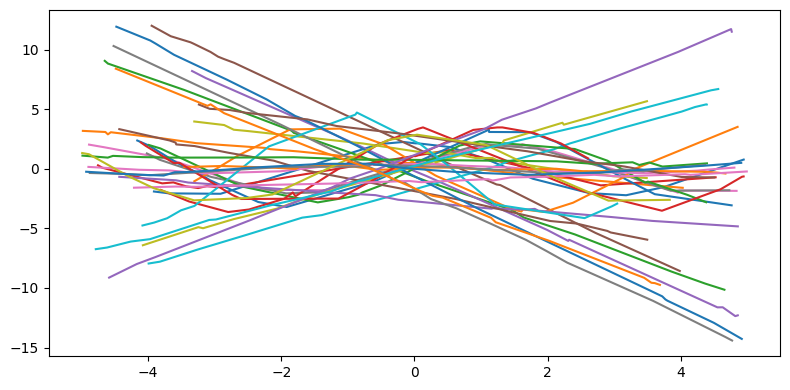

In [7]:
visualize_task(test_loader)

In [8]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="DVINP-TEST", name=get_name_dvinp(cfg))

In [ ]:
# model.freeze_decoder()
# model.freeze_encoder()

train = True

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 200
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=None,
        validate=False,
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

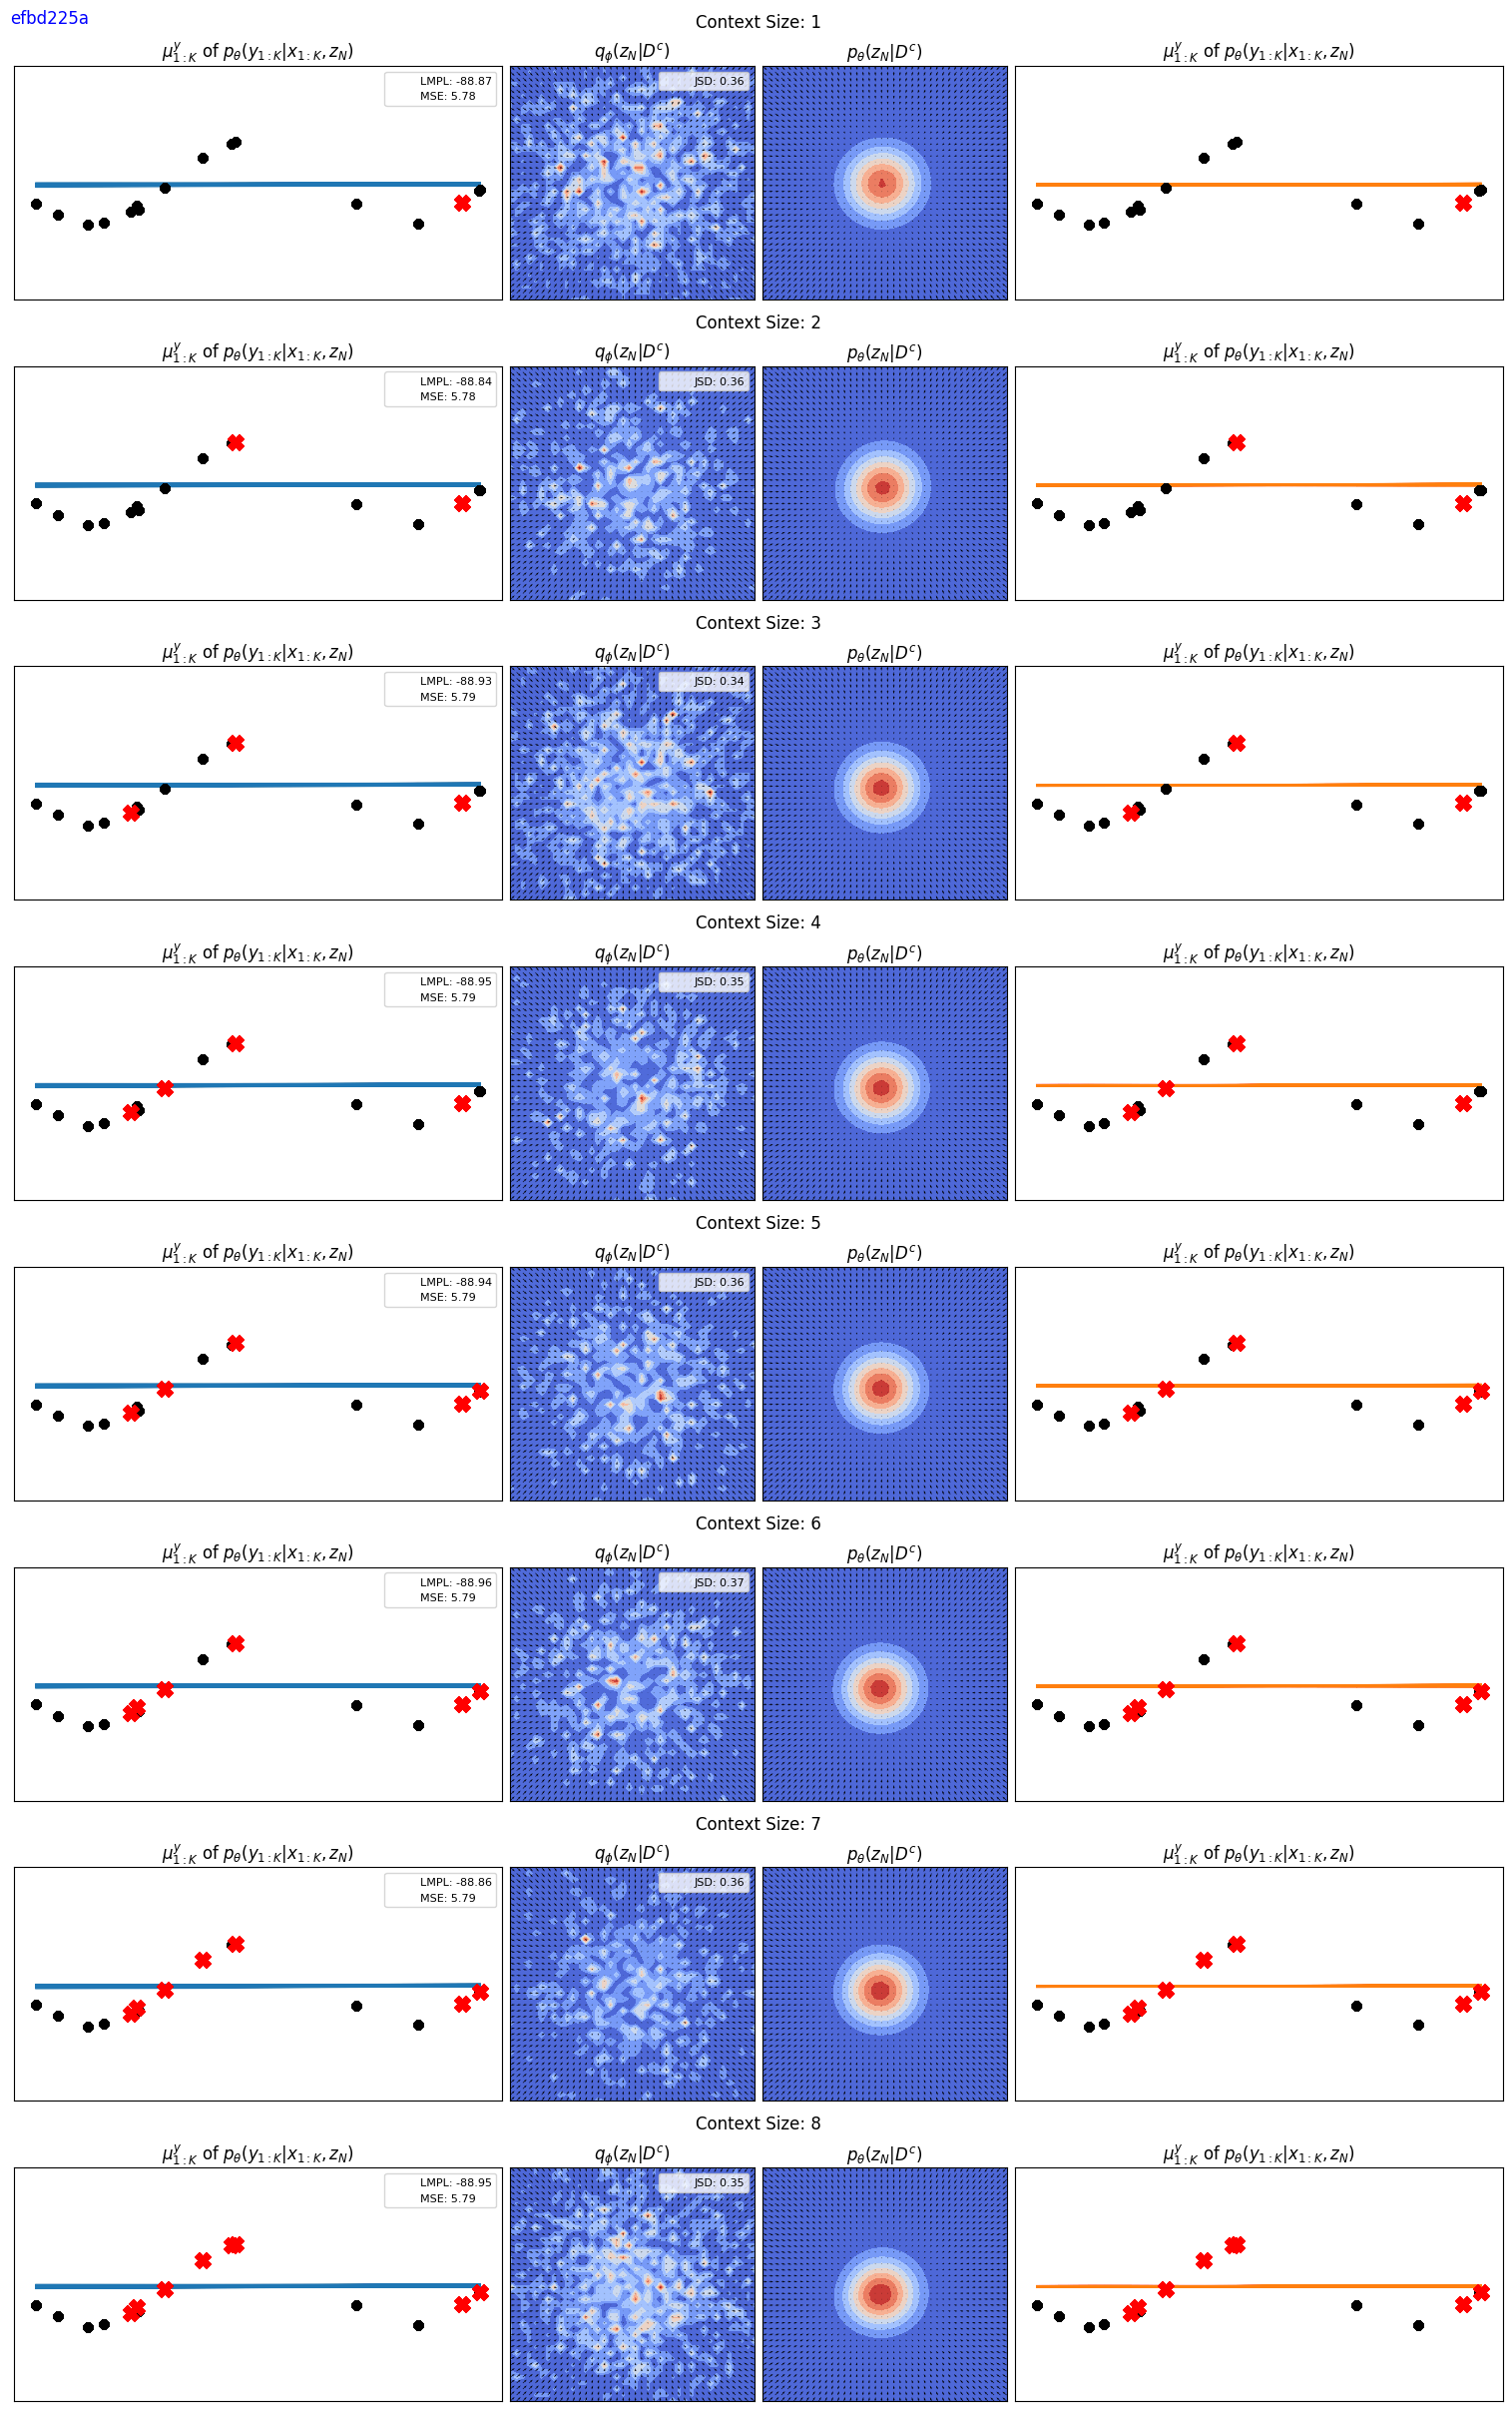

In [9]:
max_context_size = 8
num_samples = 1600  # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
    # save_dir=".",
)

In [ ]:
# from dviforbml.evaluation.num_eval_np import num_eval_np, num_eval_np_test

# num_eval_np(model, val_loader, device, 1024, "test.csv")
# num_eval_np_test(model, test_loader, device, 1024, "test.csv")

In [ ]:
# torch.save(model.state_dict(), f"{dir}/model.pth")

In [ ]:
# from dviforbml.components.cdvi.cmcd import CMCD
# from dviforbml.components.cdvi.ula import ULA
# from dviforbml.components.control.aggr_control import AggrControl
# from dviforbml.components.schedule.annealing_schedule import AggrAnnealingSchedule
# from dviforbml.components.schedule.free_noise_schedule import AggrFreeNoiseSchedule

# annealing_schedule = AggrAnnealingSchedule(
#     z_dim=cfg.model.z_dim,
#     h_dim=cfg.model.h_dim,
#     non_linearity=cfg.model.non_linearity,
#     num_steps=cfg.model.num_steps,
#     num_layers=cfg.model.num_layers_sched,
#     max_context_size=cfg.model.max_context_size,
#     device=device,
# )

# # noise_schedule = AggrFreeNoiseSchedule(
# #     z_dim=cfg.model.z_dim,
# #     h_dim=cfg.model.h_dim,
# #     num_steps=cfg.model.num_steps,
# #     num_layers=cfg.model.num_layers_sched,
# #     non_linearity=cfg.model.non_linearity,
# #     max_context_size=cfg.model.max_context_size,
# #     device=device,
# # )

# # control = AggrControl(
# #     h_dim=cfg.model.h_dim,
# #     z_dim=cfg.model.z_dim,
# #     num_steps=cfg.model.num_steps,
# #     num_layers=cfg.model.num_layers_ctrl,
# #     non_linearity=cfg.model.non_linearity,
# #     max_context_size=cfg.model.max_context_size,
# #     use_score=False,
# # )

# model.cdvi = ULA(
#     z_dim=cfg.model.z_dim,
#     num_steps=cfg.model.num_steps,
#     # control=model.cdvi.control,
#     step_size_schedule=model.cdvi.step_size_schedule,
#     noise_schedule=model.cdvi.noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device,
# )

# model = model.to(device)
# model.freeze_decoder()
# model.freeze_encoder()